In [1]:
from spikingjelly.activation_based.monitor import OutputMonitor
from spikingjelly.activation_based.layer import SynapseFilter
from spikingjelly.activation_based.neuron import LIFNode
from spikingjelly.activation_based.encoding import LatencyEncoder
from jaxtyping import Float, Int64
from torch import Tensor

import torch
import matplotlib.pyplot as plt
import wandb
import numpy as np
import spikingjelly.activation_based as snn
from spikingjelly.activation_based import surrogate, neuron, functional
from typing import Callable, Any, overload
from tqdm.auto import tqdm
from sklearn.model_selection import train_test_split

from utils.module import StochasticRound, JeffressLinear, TransposeLayer
from utils.model import CCN
from utils.datasets import generate_lp_dataset, generate_cosine_dataset, generate_1d_dot_classification_dataset, encode_temporal

In [ ]:
cfg = dict(
    NUM_SAMPLES = 10000,
    NUM_EPOCHS = 200,
    VECTOR_DIM = 3,
    MAX_VAL = 1.0,
    TIME_STEPS = 17,
    BATCH_SIZE = 256,
    NUM_CLASSES = 5
)

In [3]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# torch.autograd.set_detect_anomaly(True)

np.random.seed(42)
rng = torch.manual_seed(42)

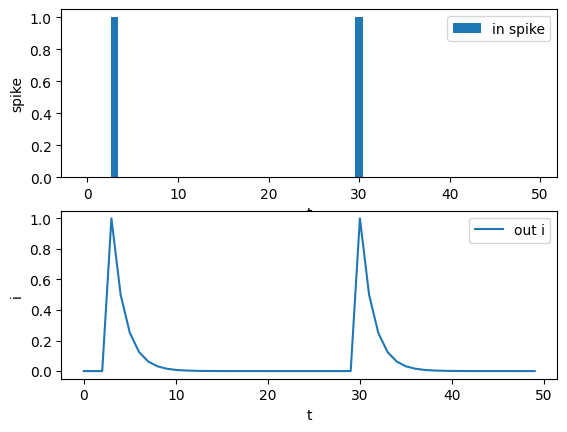

In [4]:
T = 50
in_spikes = (torch.rand(size=[T]) >= 0.95).float()
lp_syn = SynapseFilter(tau=1+1)
plt.subplot(2, 1, 1)
plt.bar(torch.arange(0, T).tolist(), in_spikes, label='in spike')
plt.xlabel('t')
plt.ylabel('spike')
plt.legend()

out_i = []
for i in range(T):
    out_i.append(lp_syn(in_spikes[i]))
plt.subplot(2, 1, 2)
plt.plot(out_i, label='out i')
plt.xlabel('t')
plt.ylabel('i')
plt.legend()
plt.show()

In [5]:
NUM_SAMPLES = cfg["NUM_SAMPLES"]  # 총 1000 개의 샘플 생성
NUM_EPOCHS = cfg["NUM_EPOCHS"]
VECTOR_DIM = cfg["VECTOR_DIM"]      # 각 벡터는 3차원
MAX_VAL = cfg["MAX_VAL"]
TIME_STEPS = cfg["TIME_STEPS"]     # SNN을 16 타임스텝 동안 실행
BATCH_SIZE = cfg["BATCH_SIZE"]
NUM_CLASSES = cfg["NUM_CLASSES"]

In [6]:
# x = torch.arange(0, TIME_STEPS, 1)
# y = x.flip(0)
# X = torch.stack([x, y], dim=-1)
# X = torch.nn.functional.one_hot(X, num_classes=TIME_STEPS)
# X = X.permute(-1, 0, 1)[:, None, ...]
# print(X.shape)
# for i in range(X.shape[-2]):
#     print(X[:,0,i,:])

In [7]:
# l = SDCLinear(TIME_STEPS, 2)
# print("X.shape:", X.shape)
# Y = l(X)
# print("Y.shape:", Y.shape)

In [8]:
torch.set_printoptions(threshold=10_000, precision=2, linewidth=160, sci_mode=False)

In [9]:
# for c in range(TIME_STEPS):
#     print(Y[:,0,c,:])

In [10]:
# model = torch.nn.Sequential(
#     SDCLinear(out_features=1).to(device),
#     LIFNode()
# )
# model

In [11]:
# X_data, y_data = generate_1d_dot_classification_dataset(NUM_SAMPLES, num_classes=NUM_CLASSES) # N 2, N 1
# X_data = torch.stack([torch.FloatTensor(encode_temporal(X_data[:,0], TIME_STEPS)),
#                       torch.FloatTensor(encode_temporal(X_data[:,1], TIME_STEPS))],
#                      dim=2) # T N 2
# y_data = torch.FloatTensor(y_data) / y_data.max() # N 1
# dataset = torch.utils.data.TensorDataset(X_data.transpose(1, 0), y_data)  # T N 2 -> N T 2

# train_set, test_set = train_test_split(dataset, test_size=0.2, random_state=42)

# train_loader = torch.utils.data.DataLoader(
#     train_set,
#     batch_size=BATCH_SIZE,
#     shuffle=True,
#     drop_last=False
#     )
# test_loader = torch.utils.data.DataLoader(
#     test_set,
#     batch_size=BATCH_SIZE,
#     shuffle=False,
#     drop_last=False
# )

# criterion = temporal_efficient_training_cross_entropy
# optimizer = torch.optim.AdamW(model.parameters(), lr=1e-3, weight_decay=0.)
# scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=120 * (NUM_SAMPLES // BATCH_SIZE))
# loss = torch.tensor(float("inf"))

# pbar = tqdm(range(120))
# pred_hist, target_hist, err_hist = [], [], []
# # wandb_table = wandb.Table(columns=[f"v_{t}" for t in range(TIME_STEPS)], log_mode="INCREMENTAL")
# with wandb.init(project="DelayedTemporal",
#                 config=cfg) as run:
#     for epoch in pbar:
#         model.train()
#         for i, batch in enumerate(tqdm(train_loader, leave=False)):
#             inputs:Float[Tensor, "N T 2 D"]; targets:Float[Tensor, "N D"]
#             inputs, targets = batch
#             inputs = inputs.to(device); targets = targets.to(device)
#             # 모델 학습 코드 추가
#             inputs = inputs.transpose(1, 0) # N T 2 -> T N 2
#             inputs = inputs[:,:,None,:] # T N 2 -> T N 1 2
#             out = model(inputs) #  -> model -> N D
#             loss = criterion(out, targets.long()) #+ model.loss
            
#             optimizer.zero_grad()
#             loss.backward()
#             optimizer.step()
            
#             pbar.set_postfix({"loss": loss.item(), "scale":(out.max()-out.min()).item()})
#             if i % 10 == 0:
#                 # wandb_table.add_data(*v_seq.mean(dim=(1,2,3)).tolist())
#                 run.log({"loss": loss.item(),
#                         "err":(out - targets).abs().mean().item()}
#                         |
#                         {f"delay_{j}": model[0]._delay[j] for j in range(model[0]._delay.shape[0])})
#         scheduler.step()
        
#         with torch.no_grad():
#             model.eval()
#             for batch in tqdm(test_loader, leave=False):
#                 inputs, targets = batch
#                 inputs = inputs.to(device); targets = targets.to(device)
#                 # 모델 학습 코드 추가
#                 out = model(inputs.transpose(1, 0)) # NT(2D)->TN(2D)->model->N
                
#                 loss = criterion(out, targets)
#                 pred_hist.extend(out.squeeze().tolist())
#                 target_hist.extend(targets.squeeze().tolist())
#                 err_hist.extend((out.squeeze() - targets.squeeze()).abs().tolist())
#                 pbar.set_postfix({"loss": loss.item(), "pred": pred_hist[-1], "target": target_hist[-1]})

In [12]:
model = CCN(vector_dim = VECTOR_DIM, cc_acc=2*TIME_STEPS-1, feature_dims=[]).to(device)
model

CCN(
  (model): Sequential(
    (0): TransposeLayer()
    (1): JeffressLinear(
      in_features=2, out_features=33
      (filter): SynapseFilter(tau=2.0, learnable=False, step_mode=m)
    )
    (2): LIFNode(
      v_threshold=1.0, v_reset=None, detach_reset=False, step_mode=m, backend=torch, tau=2.0
      (surrogate_function): ATan(alpha=2.0, spiking=True)
    )
    (3): Linear(in_features=33, out_features=1, bias=False)
    (4): Flatten(start_dim=2, end_dim=-1)
    (5): IFNode(
      v_threshold=1.0, v_reset=0.0, detach_reset=False, step_mode=m, backend=torch
      (surrogate_function): ATan(alpha=2.0, spiking=True)
    )
  )
  (linear): Linear(in_features=3, out_features=1, bias=False)
  (out_neuron): NonSpikingIFNode()
)

In [ ]:
X_data, y_data = generate_lp_dataset(NUM_SAMPLES, VECTOR_DIM, max_val=MAX_VAL)
X_data = torch.stack([torch.FloatTensor(encode_temporal(X_data[:,0,:], TIME_STEPS, time_norm=True)),
                      torch.FloatTensor(encode_temporal(X_data[:,1,:], TIME_STEPS, time_norm=True))],
                     dim=2) # T N 2D
y_data = torch.FloatTensor(y_data) / y_data.max() # N D
dataset = torch.utils.data.TensorDataset(X_data.transpose(1, 0), y_data)  # T N 2D -> N T 2D

train_set, test_set = train_test_split(dataset, test_size=0.2, random_state=42)

train_loader = torch.utils.data.DataLoader(
    train_set,
    batch_size=BATCH_SIZE,
    shuffle=True,
    drop_last=False
    )
test_loader = torch.utils.data.DataLoader(
    test_set,
    batch_size=BATCH_SIZE,
    shuffle=False,
    drop_last=False
)

criterion = torch.nn.MSELoss()
optimizer = torch.optim.AdamW(model.parameters(), lr=1e-3, weight_decay=0.)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=NUM_EPOCHS * (NUM_SAMPLES // BATCH_SIZE))
loss = torch.tensor(float("inf"))

pbar = tqdm(range(NUM_EPOCHS))
pred_hist, target_hist, err_hist = [], [], []
train_step = 0
eval_step = 0
substep = 0
with wandb.init(project="DelayedTemporal",
                config=cfg) as run:
    run.define_metric("train/*", step_metric="train_step")
    run.define_metric("delay/*", step_metric="train_step")
    run.define_metric("SDC/*", step_metric="train_step")
    run.define_metric("Mem/*", step_metric="substep")
    run.define_metric("Spike/*", step_metric="substep")
    run.define_metric("eval/*", step_metric="eval_step")
    for epoch in pbar:
        model.train()
        for i, batch in enumerate(tqdm(train_loader, leave=False)):
            inputs:Float[Tensor, "N T 2 D"]; targets:Float[Tensor, "N D"]
            inputs, targets = batch
            inputs = inputs.to(device); targets = targets.to(device)
            v_seq_pt = [] # list to save membrane potential sequences
            out = model(inputs.transpose(1, 0), v_seq_pt=v_seq_pt) # N T 2 D -> T N 2 D -> model -> N D
            loss = criterion(out, targets)
            
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            
            v_seq = v_seq_pt[-1]
            pbar.set_postfix({"loss": loss.item(), "scale":(out.max()-out.min()).item()})
            if i % 10 == 0:
                # wandb_table.add_data(*v_seq.mean(dim=(1,2,3)).tolist())
                _delay = model.model[1].delay
                run.log({
                    "train_step": (train_step := train_step + 1),
                    "train/loss": loss.item(),
                    "train/err":(out - targets).abs().mean().item(),
                    # "train/delay_grad_norm": model.model[1].delay.grad.norm().item(),
                    }|{
                        f"delay/{j}": _delay.flatten()[j] for j in range(_delay.numel())
                        # }|{
                        #     f"SDC/rate_{i}": model.stats['model.2'][-1][:,0,0,i].mean() for i in range(v_seq.shape[-1])
                            })
                for t in range(TIME_STEPS):
                    run.log({
                        "substep": (substep := substep + 1),
                    }|{
                        f"Mem/mem_{i}": v_seq[t,0,0,i] for i in range(v_seq.shape[-1])
                    }|{
                        f"Spike/rate_{i}": model.stats['model.2'][-1][t,0,0,i] for i in range(v_seq.shape[-1])
                    })
        scheduler.step()
        
        with torch.no_grad():
            model.eval()
            for batch in tqdm(test_loader, leave=False):
                inputs, targets = batch
                inputs = inputs.to(device); targets = targets.to(device)
                out = model(inputs.transpose(1, 0)) # NT(2D)->TN(2D)->model->N
                
                loss = criterion(out, targets)
                pred_hist.extend(out.squeeze().tolist())
                target_hist.extend(targets.squeeze().tolist())
                err_hist.extend((out.squeeze() - targets.squeeze()).abs().tolist())
                pbar.set_postfix({"loss": loss.item(), "pred": pred_hist[-1], "target": target_hist[-1]})
                
                run.log({"eval_step": (eval_step := eval_step + 1),
                         "eval/loss": loss.item(),
                         "eval/err":  (out - targets).abs().mean().item()})

  0%|          | 0/200 [00:00<?, ?it/s]

wandb: Currently logged in as: sizzflair97 to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


  0%|          | 0/250 [00:00<?, ?it/s]

  0%|          | 0/63 [00:00<?, ?it/s]

  0%|          | 0/250 [00:00<?, ?it/s]

  0%|          | 0/63 [00:00<?, ?it/s]

  0%|          | 0/250 [00:00<?, ?it/s]

In [ ]:
plt.title("MAE (Mean Absolute Error)")
plt.plot(err_hist, linewidth=0.03, label="Difference")
plt.ylim(-1, 1)
plt.xlabel("Iteration")
plt.ylabel("MAE")
plt.legend()

In [ ]:
# y_data

In [ ]:
for n in range(1000):
    print(abs(np.array(pred_hist)[-n] - np.array(target_hist)[-n]))